In [3]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.2 MB/s eta 0:00:00


In [8]:
import os
import torch
import random
from Levenshtein import distance as lev
from PIL import Image
import cv2
import transformers
import matplotlib.pyplot as plt
from transformers import DonutProcessor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig
from transformers import EarlyStoppingCallback
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image
import re
from torch.utils.data import Dataset, DataLoader
import warnings
from tqdm import tqdm

def decode_string(text):
    match = re.search("(.*)</s_int><s_ft>(.*)",text)
    if match:
        s1,s2 = match.groups()
    else:
        # In case there is no match!
        s1,s2 ="9","999"
    return re.sub("[^0-9]", "",s1)+"."+re.sub("[^0-9]", "",s2)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100"
# Set the path to the folder containing the JPG files
folder_path = 'WaterMeters/images'
# Get a list of all JPG files in the folder
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

In [9]:
import os
import torch
import random
from Levenshtein import distance as lev
from PIL import Image
import cv2
import transformers
import matplotlib.pyplot as plt
from transformers import DonutProcessor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig
from transformers import EarlyStoppingCallback
import numpy as np
from transformers.image_transforms import to_pil_image
import re
from torch.utils.data import Dataset, DataLoader
import warnings
from tqdm import tqdm

# Ensure torch uses CPU
device = torch.device("cpu")

def decode_string(text):
    match = re.search(r"(.*)</s_int><s_ft>(.*)", text)
    if match:
        s1, s2 = match.groups()
    else:
        # In case there is no match!
        s1, s2 = "9", "999"
    return re.sub("[^0-9]", "", s1) + "." + re.sub("[^0-9]", "", s2)

# Remove CUDA-related settings
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100"

# Set the path to the folder containing the JPG files
folder_path = 'WaterMeters/images'

# Get a list of all JPG files in the folder
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Example of using device in your model code (add when loading model)
# model = VisionEncoderDecoderModel.from_pretrained(...).to(device)
# image_tensor = image_tensor.to(device)  # move data to CPU if needed

# When defining the trainer, ensure it's compatible with CPU
# For example:
# training_args = Seq2SeqTrainingArguments(
#     ...
#     per_device_train_batch_size=1,
#     per_device_eval_batch_size=1,
#     no_cuda=True,
#     ...
# )


Avg. Width & Height of images: 1060.7073954983923 1320.112540192926
(1244, 2) <U5


Text(0.5, 0.98, 'Histograms of Images Width and Height')

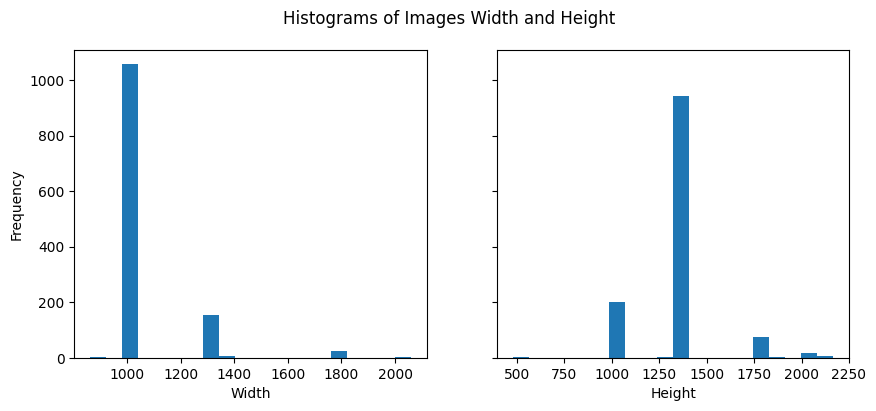

In [10]:
SIZES =[cv2.imread(os.path.join(folder_path, f)).shape for f in jpg_files]
SIZES = np.array(SIZES)[:,:2]
# Make a list of readings (ex: integer and fraction)
READINGS= np.array([re.search(r'value_([0-9]+)_([0-9]+)\.jpg',f).groups() for f in jpg_files])
img_dimension_avg = list(np.mean(SIZES,axis=0))
print("Avg. Width & Height of images:",img_dimension_avg[1],img_dimension_avg[0])
# Create a figure with two histograms side by side
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10, 4),)

# Plot the histograms
ax1.hist(SIZES[:,1], bins=20)
ax2.hist(SIZES[:,0], bins=20)

# Set the x-axis labels
ax1.set_xlabel('Width')
ax2.set_xlabel('Height')

# Set the y-axis labels
ax1.set_ylabel('Frequency')
#ax2.set_ylabel('Frequency')
print(READINGS.shape, READINGS.dtype)
# Set the title
fig.suptitle('Histograms of Images Width and Height')


In [11]:
new_special_tokens = ["<s>","<s_int>","<s_ft>","</s>","</s_int>","</s_ft>","<s_d>","</s_d>"]
# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens })

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [530,660] #[1060, 1320] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/models/donut/processing_donut.py:217: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [12]:
def prepend_and_append(input_string):
    output_string = ""
    for char in input_string:
        output_string += "<s_d>" + char + "</s_d>"
    return output_string
def transform_and_tokenize(image,text, processor=processor, split="train", max_length=32, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            image, random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(image)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        text,
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    #labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": text}



In [13]:
class CustomDataset(Dataset):
    def __init__(self, files,split='train'):
        RESIZE= (530, 660)
        folder_path = 'WaterMeters/images'
        self.pixel_values =[]
        self.labels =[]
        self.text = []
        self.split= split
        for f in files:
            image = Image.open(os.path.join(folder_path, f)).resize(RESIZE).convert('RGB')
            r1,r2 = re.search(r'value_([0-9]+)_([0-9]+)\.jpg',f).groups()
            text = "<s><s_int>"+prepend_and_append(r1)+"</s_int><s_ft>"+prepend_and_append(r2)+"</s_ft></s>"
            result = transform_and_tokenize(image,text,split=self.split)
            self.pixel_values.append(result['pixel_values'])
            self.labels.append(result['labels'])
            self.text.append(result['target_sequence'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return {'pixel_values':self.pixel_values[index],
                'labels': self.labels[index],
                'target_sequence':self.text[index]}


In [14]:
import random
random.seed(42424)
random.shuffle(jpg_files)
random.shuffle(jpg_files)
random.shuffle(jpg_files)
random.shuffle(jpg_files)
list1 = jpg_files[:880]
list2 = jpg_files[880:1060]
list3 = jpg_files[1060:]
train_dataset = CustomDataset(list1)
eval_dataset = CustomDataset(list2,split='test')
test_dataset = CustomDataset(list3,split='test')
print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.


Train dataset size: 880
Eval dataset size: 180
Test dataset size: 184


In [15]:


# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = 32
# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New embedding size: MBartScaledWordEmbedding(57531, 1024, padding_idx=1)


In [16]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("6bb18e4d0f0c489da37dfd884cedbe6f7e7c1ce9")
wandb.login(key=my_secret)

ModuleNotFoundError: No module named 'kaggle_secrets'

In [10]:
import wandb
from google.colab import userdata

# Access your wandb secret key from Colab secrets.
# Make sure you have added a secret named 'wandb_secret_key' in the Colab secrets manager.
my_secret = userdata.get('6bb18e4d0f0c489da37dfd884cedbe6f7e7c1ce9')
wandb.login(key=my_secret)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ModuleNotFoundError: No module named 'google.colab'

In [16]:

def compute_metrics(eval_pred,processor=processor):
    predictions, labels = eval_pred
    predictions = processor.batch_decode(predictions)
    labels = processor.batch_decode(labels)
    gather_list = []
    lev_dist =[]
    for prediction,target in zip(predictions, labels):
        pred_str=decode_string(prediction)
        gt_str =decode_string(target)
        lev_dist.append(lev(pred_str,gt_str))
        gather_list.append((float(pred_str),float(gt_str)))
    results = np.array(gather_list)
    abs_error = np.abs(results[:,0]-results[:,1])
    q70,q75,q80,q85= np.quantile(abs_error, [.7,0.75,.8,0.85])
    return {"q85": q85,
            "q80": q80,
            "q75":q75,
            "q70": q70,
            "avg_lev_dist":np.array(lev_dist).mean()}

In [18]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=10,
    weight_decay=0.01,
    fp16=False,            # Disable half precision for CPU
    no_cuda=True,          # Force CPU usage
    logging_steps=16,
    save_total_limit=1,
    eval_strategy="epoch",  # <- Changed this line
    save_strategy="epoch",
    predict_with_generate=True,
    report_to="wandb",
    run_name="donut-water-ft-26",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=lambda ep: compute_metrics(ep),
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1609: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=10,
    weight_decay=0.01,
    fp16=False,             # No mixed precision on CPU
    use_cpu=True,           # Updated for v4.41+
    logging_steps=16,
    save_total_limit=1,
    eval_strategy="epoch",  # Old arg, but still works
    save_strategy="epoch",
    predict_with_generate=True,
    report_to="wandb",
    run_name="donut-water-ft-26",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=lambda ep: compute_metrics(ep),
)


In [ ]:
trainer.train()

wandb-core(15593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(15598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(15603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(15606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(15631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(15667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [17]:
# Save fine tuned model
processor.save_pretrained(hf_repository_id)
trainer.save_model(hf_repository_id)

In [20]:
# Move model to GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def run_prediction_batch(test_sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"])
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids =decoder_input_ids.repeat(len(test_sample["pixel_values"]),1)
    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=2,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
    # process output
    prediction = processor.batch_decode(outputs.sequences)
    # load reference target
    target = test_sample["target_sequence"]
    return prediction, target


def run_prediction(test_sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=2,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    # load reference target
    target = test_sample["target_sequence"]
    return prediction, target

def show_prediction(test_sample):
    prediction, target = run_prediction(test_sample)
    prediction, target = decode_string(prediction),decode_string(target)
    print(f"Reading\n {target}")
    #print(f"Prediction:\n {prediction}")
    pixel = np.array(test_sample["pixel_values"])
    M=np.max(pixel)
    m=np.min(pixel)
    return to_pil_image(np.uint8(255*(pixel-m)/(M-m)))

In [25]:
def run_prediction(test_sample, model=model, processor=processor):
    # safer conversion
    pixel_values = torch.as_tensor(test_sample["pixel_values"]).unsqueeze(0).to(device)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)

    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=2,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    prediction = processor.batch_decode(outputs.sequences)[0]
    target = test_sample["target_sequence"]
    return prediction, target


def show_prediction(test_sample):
    prediction, target = run_prediction(test_sample)
    prediction, target = decode_string(prediction), decode_string(target)
    print(f"Reading:\n {target}")
    #print(f"Prediction:\n {prediction}")

    # safer numpy conversion
    if isinstance(test_sample["pixel_values"], torch.Tensor):
        pixel = test_sample["pixel_values"].cpu().numpy()
    else:
        pixel = np.array(test_sample["pixel_values"], copy=False)

    M = np.max(pixel)
    m = np.min(pixel)
    return to_pil_image(np.uint8(255 * (pixel - m) / (M - m)))
    s


wandb-core(29541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29545) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Reading:
 436.101


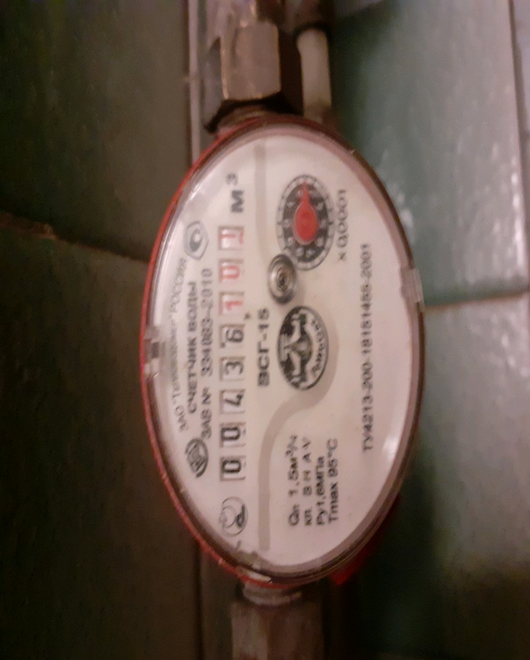

wandb-core(31371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [37]:
# Load random document image from the test set
test_sample = test_dataset[random.randint(1, 184)]
show_prediction(test_sample)

In [27]:
!pip install fastapi uvicorn python-multipart


Python(29562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


wandb-core(29563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [28]:
%%writefile main.py
from fastapi import FastAPI

app = FastAPI()

@app.get("/")
def read_root():
    return {"Hello": "World"}


Writing main.py


wandb-core(29565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [29]:
%%writefile main.py
from fastapi import FastAPI
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel

app = FastAPI()

# Load the fine-tuned processor and model
hf_repository_id = "donut-base-water"
processor = DonutProcessor.from_pretrained(hf_repository_id)
model = VisionEncoderDecoderModel.from_pretrained(hf_repository_id)

# Move model to GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

@app.get("/")
def read_root():
    return {"Hello": "World"}


Overwriting main.py


wandb-core(29570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [30]:
%%writefile main.py
from fastapi import FastAPI, File, UploadFile
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import io

app = FastAPI()

# Load the fine-tuned processor and model
hf_repository_id = "donut-base-water"
processor = DonutProcessor.from_pretrained(hf_repository_id)
model = VisionEncoderDecoderModel.from_pretrained(hf_repository_id)

# Move model to GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

@app.get("/")
def read_root():
    return {"Hello": "World"}

@app.post("/predict")
async def predict_water_meter(file: UploadFile = File(...)):
    # Read the image file
    image_data = await file.read()
    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    # TODO: Add prediction logic here

    return {"filename": file.filename}

Overwriting main.py


wandb-core(29601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [31]:
%%writefile main.py
from fastapi import FastAPI, File, UploadFile
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import io

app = FastAPI()

# Load the fine-tuned processor and model
hf_repository_id = "donut-base-water"
processor = DonutProcessor.from_pretrained(hf_repository_id)
model = VisionEncoderDecoderModel.from_pretrained(hf_repository_id)

# Move model to GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

@app.get("/")
def read_root():
    return {"Hello": "World"}

@app.post("/predict")
async def predict_water_meter(file: UploadFile = File(...)):
    # Read the image file
    image_data = await file.read()
    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    # Preprocess the image using the processor
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Prepare the decoder input IDs
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
    decoder_input_ids = decoder_input_ids.repeat(pixel_values.shape[0], 1) # Repeat for batch size (which is 1)


    # TODO: Add prediction logic here

    return {"filename": file.filename}

Overwriting main.py


wandb-core(29612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [32]:
%%writefile main.py
from fastapi import FastAPI, File, UploadFile
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import io

app = FastAPI()

# Load the fine-tuned processor and model
hf_repository_id = "donut-base-water"
processor = DonutProcessor.from_pretrained(hf_repository_id)
model = VisionEncoderDecoderModel.from_pretrained(hf_repository_id)

# Move model to GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

@app.get("/")
def read_root():
    return {"Hello": "World"}

@app.post("/predict")
async def predict_water_meter(file: UploadFile = File(...)):
    # Read the image file
    image_data = await file.read()
    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    # Preprocess the image using the processor
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Prepare the decoder input IDs
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
    decoder_input_ids = decoder_input_ids.repeat(pixel_values.shape[0], 1) # Repeat for batch size (which is 1)

    # Perform inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=2,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # TODO: Process and return prediction

    return {"filename": file.filename}

Overwriting main.py


wandb-core(29618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [33]:
%%writefile main.py
from fastapi import FastAPI, File, UploadFile
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import io
import re

app = FastAPI()

# Load the fine-tuned processor and model
hf_repository_id = "donut-base-water"
processor = DonutProcessor.from_pretrained(hf_repository_id)
model = VisionEncoderDecoderModel.from_pretrained(hf_repository_id)

# Move model to GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Function to decode the string format
def decode_string(text):
    match = re.search("(.*)</s_int><s_ft>(.*)",text)
    if match:
        s1,s2 = match.groups()
    else:
        # In case there is no match!
        s1,s2 ="9","999"
    return re.sub("[^0-9]", "",s1)+"."+re.sub("[^0-9]", "",s2)


@app.get("/")
def read_root():
    return {"Hello": "World"}

@app.post("/predict")
async def predict_water_meter(file: UploadFile = File(...)):
    # Read the image file
    image_data = await file.read()
    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    # Preprocess the image using the processor
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Prepare the decoder input IDs
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
    decoder_input_ids = decoder_input_ids.repeat(pixel_values.shape[0], 1) # Repeat for batch size (which is 1)

    # Perform inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=2,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # Decode the output sequence
    decoded_sequence = processor.batch_decode(outputs.sequences)[0]
    decoded_reading_string = decode_string(decoded_sequence)

    # Return the prediction as a JSON object
    return {"filename": file.filename, "prediction": decoded_reading_string}

Overwriting main.py


In [34]:
!uvicorn main:app --reload --host 0.0.0.0 --port 8000 &

OSError: Background processes not supported.

wandb-core(29622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(29634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
import os
os.system("uvicorn main:app --reload --host 0.0.0.0 --port 8000")


INFO:     Will watch for changes in these directories: ['/Users/harshit/Desktop/final code']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [29635] using StatReload
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
INFO:     Started server process [29639]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
